# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 7
# LDA/QDA and Decision Trees

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately):

Enrollment Status (109A, 121A, 209A, or E109A): 209A

Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
import sklearn.metrics as metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
#import pydotplus
#import io
from sklearn.tree import export_graphviz
from IPython.display import Image
from IPython.display import display
%matplotlib inline

import seaborn as sns
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

sns.set_context('poster')


## Multiclass Thyroid Classification

In this problem, you will build a model for diagnosing disorders in a patient's thyroid gland. Given the results of medical tests on a patient, the task is to classify the patient either as:
- *normal* (class 1)
- having *hyperthyroidism* (class 2)
- or having *hypothyroidism* (class 3). 

The data set is provided in the file `hw7_dataset.csv`. Columns 1-2 contain biomarkers for a patient (predictors):
- Biomarker 1: (Logarithm of) level of basal thyroid-stimulating hormone (TSH) as measured by radioimmuno assay
- Biomarker 2: (Logarithm of) maximal absolute difference of TSH value after injection of 200 micro grams of thyrotropin-releasing hormone as compared to the basal value.

The last column contains the diagnosis for the patient from a medical expert. This data set was obtained from the UCI machine learning repository.

Notice that unlike previous exercises, the task at hand is a 3-class classification problem. We will explore the use of different methods for multiclass classification.

First task: split the data using the following code:

In [2]:
np.random.seed(9001)
df = pd.read_csv('hw7_dataset.csv')
msk = np.random.rand(len(df)) < 0.5
data_train = df[msk]
data_test = df[~msk]

In [3]:
print(data_train.shape)
print(data_test.shape)
print(data_train.head())

(102, 3)
(113, 3)
    Biomarker 1  Biomarker 2  Diagnosis
0      0.262372     0.875473        1.0
5      0.336479     1.098616        1.0
9      0.182330    -1.609488        2.0
12    -0.223131     0.788462        1.0
13     0.587792     1.458617        1.0


## Question 1: Fit Classification Models

1. Generate a 2D scatter plot of the training set, denoting each class with a different color. Does it appear that the data points can be separated well by a linear classifier?

2. Briefly explain the difference between multinomial logistic regression and one-vs-rest (OvR) logistic regression methods for fitting a multiclass classifier (in 2-3 sentences).

3. Fit linear classification models on the thyroid data set using both the methods.  You should use $L_2$ regularization in both cases, tuning the regularization parameter using cross-validation.  Is there a difference in the overall classification accuracy of the two methods on the training and test sets?

4. Also, compare the training and test accuracies of these models with the following classification methods:
    - Multiclass Logistic Regression with quadratic terms 
    - Linear Discriminant Analysis
    - Quadratic Discriminant Analysis
    - k-Nearest Neighbors
    <br>
*Note:* you may use either the OvR or multinomial variant for the multiclass logistic regression (with $L_2$ regularization). Do not forget to use cross-validation to choose the regularization parameter, and also the number of neighbors in k-NN. 

5. Does the inclusion of the polynomial terms in logistic regression yield better test accuracy compared to the model with only linear terms? 


*Hint:* You may use the `KNeighborsClassifier` class to fit a k-NN classification model.

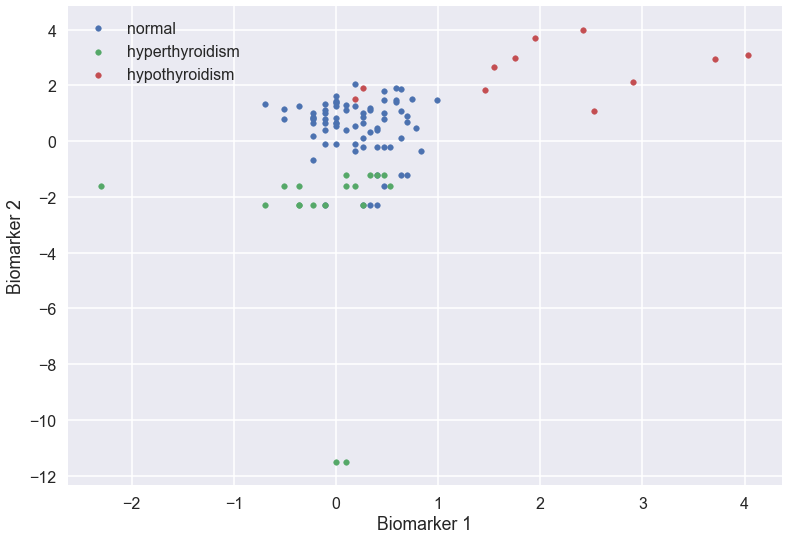

In [4]:
# 1

labels = ['normal', 'hyperthyroidism', 'hypothyroidism']
for i, label in enumerate(labels):
    plt.scatter(data_train[data_train.Diagnosis==i+1]['Biomarker 1'], \
                data_train[data_train.Diagnosis==i+1]['Biomarker 2'], marker='.', label=label)
plt.legend();
plt.xlabel('Biomarker 1');
plt.ylabel('Biomarker 2');

According to the plot, it seems the data points could be separated well by a linear classifier.

#### 2. Answer:
Multinomial logistic regression sets one of the categories in the response variable as the reference group, and then fits separate classifiers to predict the other categories (versus the reference group). One-vs-rest logistic regression trains a single classifier for each class, with the samples from that class as positives and all other samples as negatives.

Multinomial logistic relies on the (not always realistic) assumption of independence of irrelevant alternatives whereas a series of binary logistic predictions does not. But the complexity of ovr would be higher, since it needs to do logistic regression for n times(n : number of classes).

In [5]:
# 3

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

X_train = data_train.iloc[:, :-1].values
y_train = data_train.iloc[:, -1].values
X_test = data_test.iloc[:, :-1].values
y_test = data_test.iloc[:, -1].values

# Standardize

scaler = StandardScaler().fit(X_train)
X_train_normed = scaler.transform(X_train)
X_test_normed = scaler.transform(X_test)

# Fitting

l1 = LogisticRegressionCV(multi_class='multinomial').fit(X_train_normed, y_train)
l2 = LogisticRegressionCV(multi_class='ovr').fit(X_train_normed, y_train)

y_train_pred1 = l1.predict(X_train_normed)
y_test_pred1 = l1.predict(X_test_normed)
y_train_pred2 = l2.predict(X_train_normed)
y_test_pred2 = l2.predict(X_test_normed)

train_accuracy1 = accuracy_score(y_train, y_train_pred1)
train_accuracy2 = accuracy_score(y_train, y_train_pred2)
test_accuracy1 = accuracy_score(y_test, y_test_pred1)
test_accuracy2 = accuracy_score(y_test, y_test_pred2)

print('Multinomial logistic regression: accuracy on training set is {};accuracy on test set is {}.'.\
     format(train_accuracy1, test_accuracy1))
print('One-vs-rest logistic regression: accuracy on training set is {};accuracy on test set is {}.'.\
     format(train_accuracy2, test_accuracy2))

Multinomial logistic regression: accuracy on training set is 0.8921568627450981;accuracy on test set is 0.8849557522123894.
One-vs-rest logistic regression: accuracy on training set is 0.8725490196078431;accuracy on test set is 0.8672566371681416.


The classification accuracy on the test set is slightly lower than that on the training set for both methods. The classification accuracy of multinomial logistic regression is slightly higher than that of one-vs-rest (OvR) logistic regression on either training set or test set.

In [6]:
# 4

def get_accuracy(model, X_train=X_train_normed, X_test=X_test_normed, y_train=y_train, y_test=y_test):
    model = model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    return accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred), model

# Multiclass Logistic Regression with quadratic terms

X_train_normed_quad = PolynomialFeatures(2, include_bias=False).fit_transform(X_train_normed)
X_test_normed_quad = PolynomialFeatures(2, include_bias=False).fit_transform(X_test_normed)

a41 = get_accuracy(LogisticRegressionCV(multi_class='multinomial'), X_train_normed_quad, X_test_normed_quad)

# Linear Discriminant Analysis

a42 = get_accuracy(LinearDiscriminantAnalysis())

# Quadratic Discriminant Analysis

a43 = get_accuracy(QuadraticDiscriminantAnalysis())

The selected number of neighbors is 3.


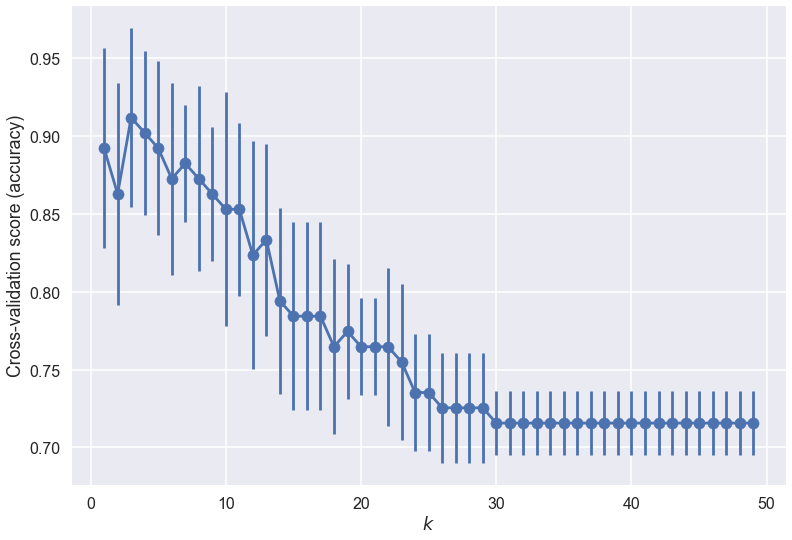

In [7]:
# Use cross-validation to choose the number of neighbors in k-NN

from sklearn.model_selection import GridSearchCV

ks = [i for i in range(1, 50)]
gs = GridSearchCV(KNeighborsClassifier(), {'n_neighbors':ks}, cv=5)
gs.fit(X_train_normed, y_train)

a44 = get_accuracy(gs)

print('The selected number of neighbors is {}.'.format(ks[np.argmax(gs.cv_results_['mean_test_score'])]))

plt.scatter(ks, gs.cv_results_['mean_test_score'])
plt.errorbar(ks, gs.cv_results_['mean_test_score'], gs.cv_results_['std_test_score'])
plt.xlabel('$k$');
plt.ylabel('Cross-validation score (accuracy)');

In [8]:
print('Multiclass Logistic Regression with quadratic terms: accuracy on training set is  {}; accuracy on test set is {}.'.\
     format(a41[0], a41[1]))
print('Linear Discriminant Analysis: accuracy on training set is  {}; accuracy on test set is {}.'.\
     format(a42[0], a42[1]))
print('Quadratic Discriminant Analysis: accuracy on training set is  {}; accuracy on test set is {}.'.\
     format(a43[0], a43[1]))
print('k-Nearest Neighbors: accuracy on training set is  {}; accuracy on test set is {}.'.\
     format(a44[0], a44[1]))

Multiclass Logistic Regression with quadratic terms: accuracy on training set is  0.8823529411764706; accuracy on test set is 0.8761061946902655.
Linear Discriminant Analysis: accuracy on training set is  0.8725490196078431; accuracy on test set is 0.831858407079646.
Quadratic Discriminant Analysis: accuracy on training set is  0.8725490196078431; accuracy on test set is 0.8495575221238938.
k-Nearest Neighbors: accuracy on training set is  0.9411764705882353; accuracy on test set is 0.8849557522123894.


As we can see, the kNN classifier yields best accuracy on test set; multiclass logistic regression with quadratic terms yields slightly lower accuracy on test set; test accuracies of LDA and QDA are lower than other 2 methods, where that of LDA is slightly lower than that of QDA. In terms of training accuracy, that of kNN is higher than other methods, where training accuracy of multiclass logistic regression with quadratic terms is slightly higher than LDA and QDA.

#### 5. Answer:
The inclusion of the polynomial terms in logistic regression doesn't yield better accuracy compared to the model with only linear terms, indicating it might not be necessary to include polynomial terms. Including quadratic terms might need to overfitting.

## Question 2: Visualize Decision Boundaries

The following code will allow you to visualize the decision boundaries of a given classification model.

In [9]:
#--------  plot_decision_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (predictors)
#      y (labels)
#      model (the classifier you want to visualize)
#      title (title for plot)
#      ax (a set of axes to plot on)
#      poly_degree (highest degree of polynomial terms included in the model; None by default)

def plot_decision_boundary(x, y, model, title, ax, poly_degree=None):
    # Create mesh
    # Interval of points for biomarker 1
    min0 = x[:,0].min()
    max0 = x[:,0].max()
    interval0 = np.arange(min0, max0, (max0-min0)/100)
    n0 = np.size(interval0)
    
    # Interval of points for biomarker 2
    min1 = x[:,1].min()
    max1 = x[:,1].max()
    interval1 = np.arange(min1, max1, (max1-min1)/100)
    n1 = np.size(interval1)

    # Create mesh grid of points
    x1, x2 = np.meshgrid(interval0, interval1)
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(-1,1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh of points
    # Check if polynomial terms need to be included
    if(poly_degree!=None):
        # Use PolynomialFeatures to generate polynomial terms
        poly = PolynomialFeatures(poly_degree, include_bias=False)
        xx_ = poly.fit_transform(xx)
        yy = model.predict(xx_) 
    else:   
        yy = model.predict(xx)
        
    yy = yy.reshape((n0, n1))

    # Plot decision surface
    x1 = x1.reshape(n0, n1)
    x2 = x2.reshape(n0, n1)
    ax.contourf(x1, x2, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    
    # Plot scatter plot of data
    yy = y.reshape(-1,)
    ax.scatter(x[yy==1,0], x[yy==1,1], c='blue', label='Normal', cmap=plt.cm.coolwarm)
    ax.scatter(x[yy==2,0], x[yy==2,1], c='cyan', label='Hyper', cmap=plt.cm.coolwarm)
    ax.scatter(x[yy==3,0], x[yy==3,1], c='red', label='Hypo', cmap=plt.cm.coolwarm)
    
    # Label axis, title
    ax.set_title(title)
    ax.set_xlabel('Biomarker 1')
    ax.set_ylabel('Biomarker 2')

**Note:** The provided code uses `sklearn`'s `PolynomialFeatures` to generate higher-order polynomial terms, with degree `poly_degree`. 
Also, if you have loaded the data sets into `pandas` data frames, you may use the `as_matrix` function to obtain a `numpy` array from the data frame objects.

1. Use the above code to visualize the decision boundaries for each of the model fitted in the previous part.
2. Comment on the difference in the decision boundaries (if any) for the OvR and multinomial logistic regression models. Is there a difference between the decision boundaries for the linear logistic regression models and LDA. What about the decision boundaries for the quadratic logistic regression and QDA? Give an explanation for your answer.

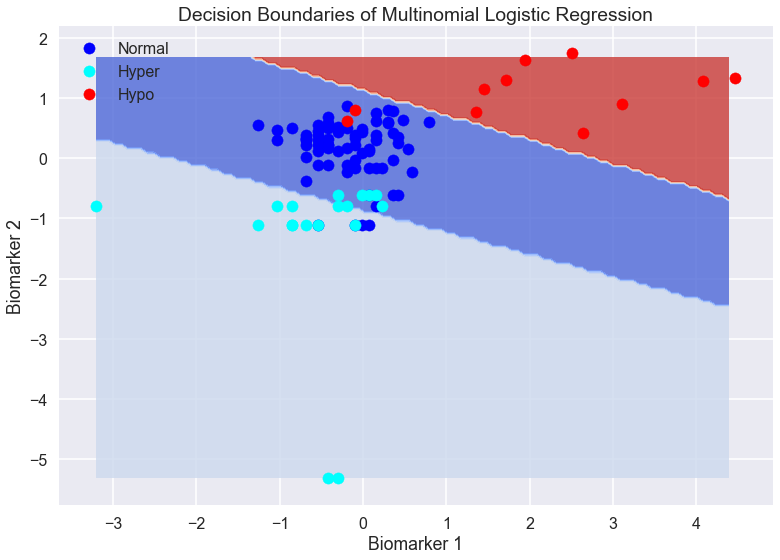

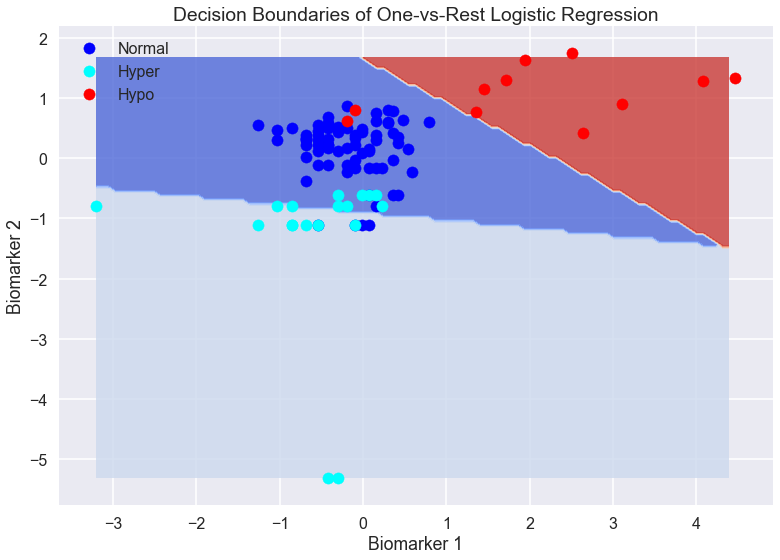

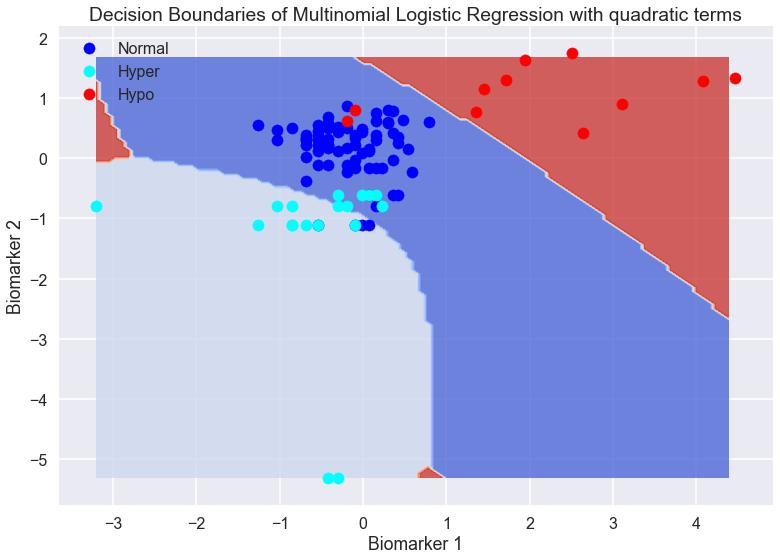

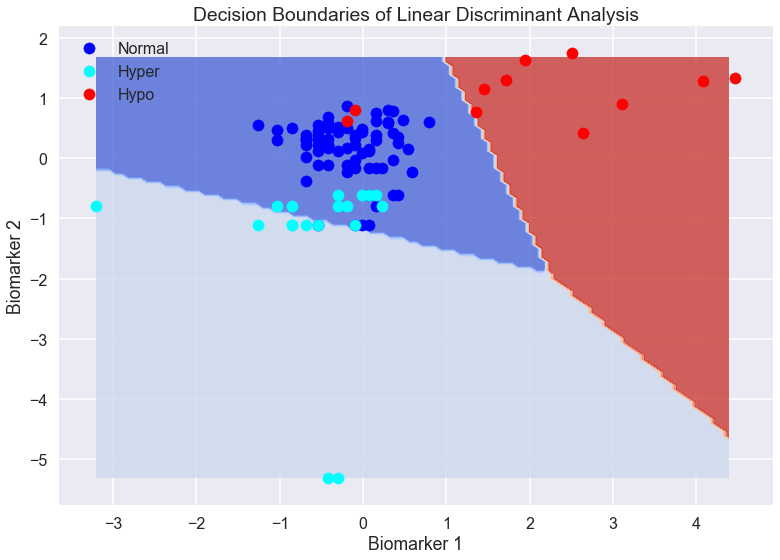

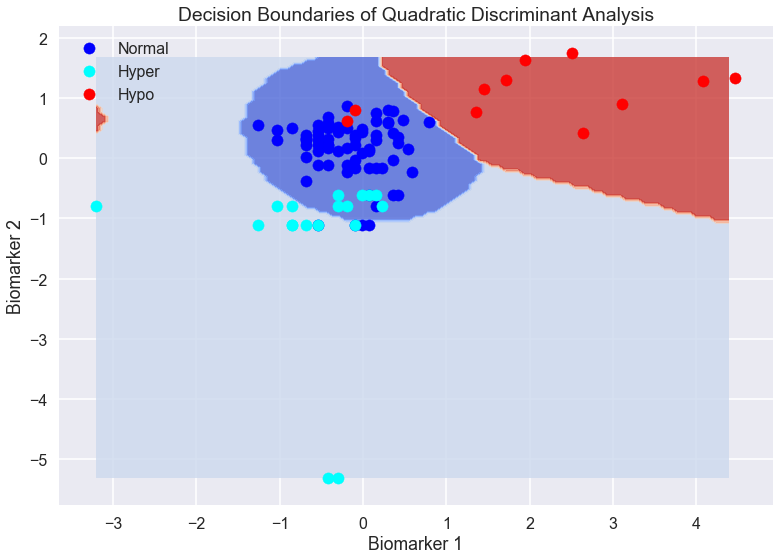

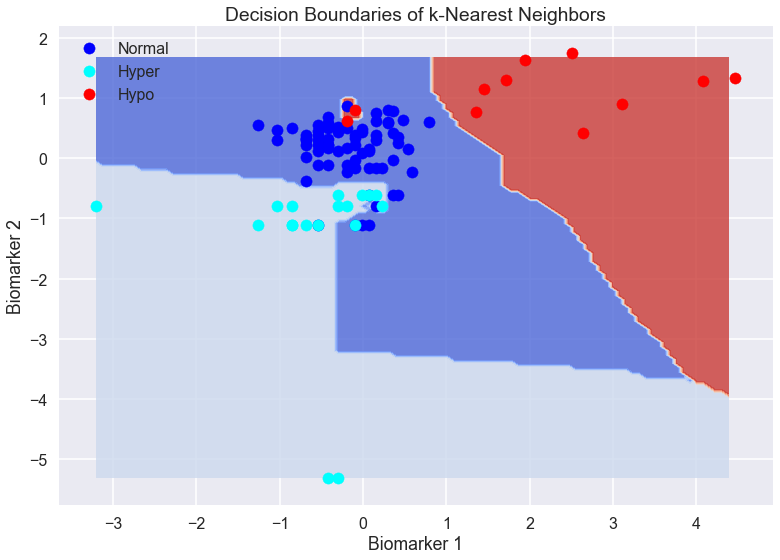

In [10]:
models = [l1, l2, a41[2], a42[2], a43[2], a44[2]]
titles = ['Decision Boundaries of Multinomial Logistic Regression',
         'Decision Boundaries of One-vs-Rest Logistic Regression',
         'Decision Boundaries of Multinomial Logistic Regression with quadratic terms',
         'Decision Boundaries of Linear Discriminant Analysis',
         'Decision Boundaries of Quadratic Discriminant Analysis',
         'Decision Boundaries of k-Nearest Neighbors']
pds = [None, None, 2, None, None, None]
for i in range(len(models)):
    figs, axes = plt.subplots(1, 1)
    plot_decision_boundary(X_train_normed, y_train, models[i], titles[i], axes, pds[i])
    plt.legend()

#### 2. Answer:

**(OvR vs multinomial logistic regression)** Both decision boundries are linear. The decision boundries for the multinomial logistic regression model seems to be nearly parallel to each other, while there seems to be a non-zero angle between 2 decision boundries for the OvR model. The multinomial model chooses a reference group, fits 2 models for the other groups against the reference group and makes decisions, which are determined by their comparison to the reference group; as a result, the decision boundries could be less sensitive to the distribution of data points in each class and thus seem to be parallel to each other. The decision boundries of OvR method, which seperate data points in each group from those in all other groups, could be more sensitive to the (relative) distributions of data points in different groups and result in a non-zero angle between them.

**(linear logistic regression vs LDA)** Both decision boundries are linear. There are mainly 2 differences: (1) 3 decision boundries appear on the plot for LDA and each decision boundry seems to be (nearly) vertical to the line connecting the center of each class, while only 2 decision boundries appear on the plot for the linear logistic regression models and angles are different; (2) the decision boundries of LDA seem to be more sensitive to outliers. Both could be explained by the fact that non-linear logistic function is used in logistic function to model the probability while only the mean and covariance of predictors (as well as priors) are used to determine the decision boundries.

**(quadratic logistic regression vs QDA)** Both decision boundries are non-linear. The decision boundries enclose the "normal" group, which is between other 2 groups, in a narrow area for QDA, while there seems to be a widely open area of "normal" group for quadratic logistic regression model. Large variances of data points in other 2 groups contribute to an enclosed narrow decision area for the "normal" group; by contrast, quadratic logistic regression model, which makes decision based on the logistic function enabled probability estimate, is less sensitive to such factor.

## Question 3: Fit Decision Trees

We next try out decision trees for thyroid classification. For the following questions, you may use the *Gini* index as the splitting criterion while fitting the decision tree. 
1. Fit a decision tree model to the thyroid data set with (maximum) tree depths 2, 3, ..., 10. Make plots of the training and test accuracies as a function of the tree depth. Is there a depth at which the fitted decision tree model achieves near-perfect classification on the training set? If so, what can you say about the test accuracy of this model?

2. Use 5-fold cross-validation to find the optimal tree depth. How does the performance of a decision tree fitted with this depth compare with the models fitted in Part 2(a)?

3. Use the code provided in Part 2(c) to visualize the decision boundary of the fitted decision tree. How is the decision boundary of the decision tree model different from the other methods? Given an explanation for your observation.

4. Use the `export_graphviz` function in `sklearn` to generate a visualization of the tree diagram for the fitted model. Based on the visualization, explain *in words* how the fitted model diagnoses 'hypothyroidism' for a patient.  


*Note:* Look at the `export_graphviz` function in the `sklearn.tree` module. 

You can get a graphic for this visualization by pasting the generated graphviz file in the text box at http://www.webgraphviz.com/ , or you can do it on your own computer.

If you choose the do the latter, you will have to install `GraphViz` and `pydot` to use the decision tree rendering code. For this, you may execute the following commands in a terminal:

`$pip install graphviz`<br>
`$pip install pydot`

*Hint:* You may use the `DecisionTreeClassifier` class to fit a decision tree classifier and the `max_depth` attribute to set the tree depth. You may use the `cross_val_score` function for cross-validation with decision trees.

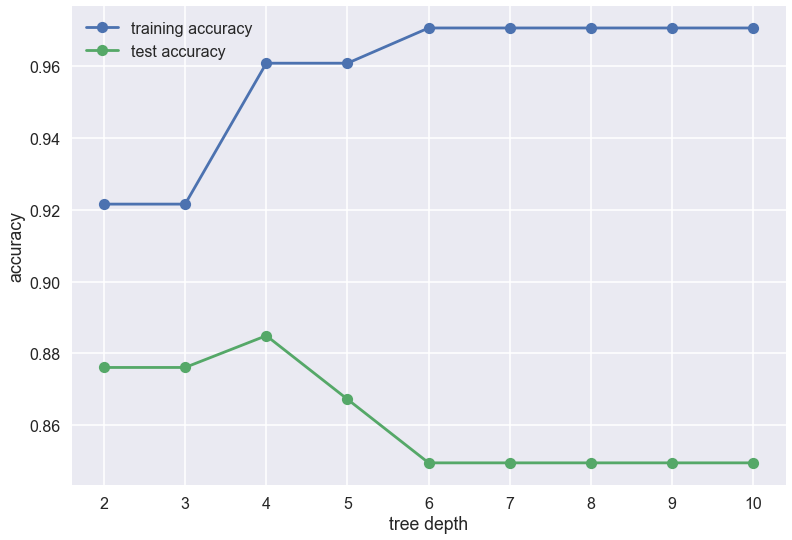

In [11]:
# 1

def get_accuracy(model, X_train=X_train_normed, X_test=X_test_normed, y_train=y_train, y_test=y_test):
    model = model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    return accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred), model

depths = [i for i in range(2, 11)]
train_accuracies = []
test_accuracies = []

for d in depths:
    model = DecisionTreeClassifier(max_depth=d)
    a = get_accuracy(model)
    train_accuracies.append(a[0])
    test_accuracies.append(a[1])

plt.plot(depths, train_accuracies, 'o-', label='training accuracy');
plt.plot(depths, test_accuracies, 'o-', label='test accuracy');
plt.xlabel('tree depth');
plt.ylabel('accuracy');
plt.legend();

Near-perfect classification on the training set is achieved for tree depths at 7, 8, 9, 10; however, the test acurracies for these depths are lower than those for lower depths, indicating the model might suffer from overfitting when the tree depth is too high.

The optimal tree depth (determined by 5-fold cross-validation) is 2.


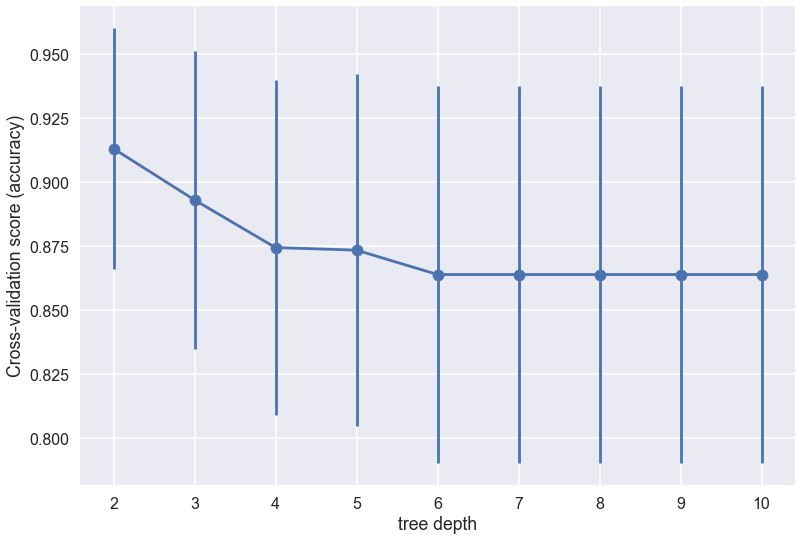

In [12]:
# 2

depths = [i for i in range(2, 11)]
scores = []
for d in depths:
    scores.append(cross_val_score(DecisionTreeClassifier(max_depth=d), X=X_train_normed, y=y_train, cv=5))
    
plt.scatter(depths, np.mean(scores, axis=1))
plt.errorbar(depths, np.mean(scores, axis=1), np.std(scores, axis=1))
plt.xlabel('tree depth');
plt.ylabel('Cross-validation score (accuracy)');

d_optimal = depths[np.argmax(np.mean(scores, axis=1))]
print('The optimal tree depth (determined by 5-fold cross-validation) is {}.'.format(d_optimal))

In [13]:
model = DecisionTreeClassifier(max_depth=d_optimal)

a = get_accuracy(model)

print('Decision tree (depth {}): training accuracy is {}; test accuracy is {}.'.format(d_optimal, a[0], a[1]))

Decision tree (depth 2): training accuracy is 0.9215686274509803; test accuracy is 0.8761061946902655.


The training accuracy is higher than that of (multinomial, OvR, or quadratic) logistic regression, LDA or QDA, but is slightly lower than that of kNN model. The test accuracy is higher than that of LDA or QDA and is at the same level with (multinomial, OvR, or quadratic) logistic regression or kNN.

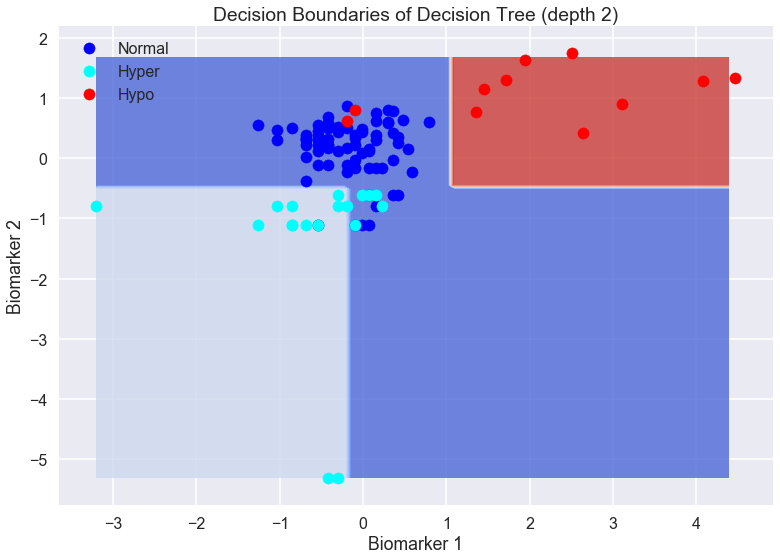

In [14]:
# 3
title = 'Decision Boundaries of Decision Tree (depth {})'.format(d_optimal)

figs, axes = plt.subplots(1, 1)
plot_decision_boundary(X_train_normed, y_train, model, title, axes)
plt.legend();

The prediction regions are composed of blocks of rectangles; the decision boudaries are made of lines parallel to one of the axes. We split regions (or sub-regions) on each axis (predictor) when fitting decision trees; as a result, decision boundries are locally parallel to one of the axes.

In [15]:
# 4

feature_names = ['Biomarker 1', 'Biomarker 2']
class_names = ['Normal', 'Hyperthyroidism', 'Hypothyroidism']

export_graphviz(model, feature_names=feature_names, class_names=class_names)

/Users/wyssuser/anaconda/lib/python3.6/site-packages/sklearn/tree/export.py:386: DeprecationWarning: out_file can be set to None starting from 0.18. This will be the default in 0.20.
  DeprecationWarning)


<img src='tree.png'>

The model firstly checks whether the normed read of biomarker 2 is larger than -0.4951; if yes, it then checks whether the normed read of biomarker 1 is larger than 1.0675; if yes, the patient would be diagnosed as 'hypothyroidism'.

## Question 4: Too many models to choose from!

We have so far seen six different ways of fitting a classification model for thyroid classification problem: **linear logistic regression**, **logistic regression with polynomial terms**, **LDA**, **QDA**, **k-NN** and **decision tree**. Which of these methods should one use in practice? To answer this question, we now look at the pros and cons of each method.

1. Compare and contrast the six models based on each of the following criteria (a supporting table to summarize your  thoughts can be helpful):
  - Classification performance
  - Complexity of decision boundary
  - Memory storage
  - Ease of interpretability

2. If you were a clinician who had to use the classifier to diagnose thyroid disorders in patients, which among the six methods would you be most comfortable in using? 

#### 1. Answer:

**(Classification performance)** 
1. **Linear logistic regression** and **LDA** perform well when the classes can be well-separated by linear decision boundries. 
2. **Logistic regression with polynomial terms** outperforms **linear logistic regression** when the classes can be better-separated by some non-linear decision boundries than linear decision boundries.
3. **LDA** outperforms **logistic regression** when the distribution of predictors is reasonably MVN with constant covariance.
4. **QDA** outperforms **LDA** when the covaiances are not the same in the groups.
5. **Linear logistic regression** (**LDA**) might outperfom **logistic regression with polynomial terms** (**QDA**) when the training set is small due to smaller chance of overfitting.
6. **k-NN** outperforms **logistic regression**, **LDA** and **QDA** when the decision boundary is extremely non-linear.
7. **Decision tree** outperforms **logistic regression**, **LDA** and **QDA** when the decision boundries cannot be described by single equations.
8. **k-NN**, as a lazy learner (instance-based), is fit for incremental learning, while other classifiers (**logistic regression**, **LDA**, **QDA** and **decision tree**) are not fit since they are eager learners (model-based).

**(Complexity of decision boundary)**
1. The decision boundaries of **linear logistic regression** and **LDA** are linear and can be described by single equations.
2. The decision boundaries of **logistic regression with polynomial terms** and **QDA** can be non-linear but cannot be arbitrarily complicated (depending on the number and the degree of polynomial terms added for logistic regression model).
3. The decision boundaries of **decision tree** are locally linear and can be sufficiently complex (depending on the depth).
4. The decision boundaries of **k-NN** can be extremely non-linear and arbitrarily complicated (for some well-tuned $k$).

**(Memory storage)** 
Let $n$ be the number of training samples, $p$ be the number of features, $p_{poly}$ be the total number of features plus polynomial terms (for logistic regression model with polynomial terms), and $K$ be the number of classes.

1. **Linear logistic regression** needs to store $O(p)$ coefficients for each class and thus needs to store $O(pK)$ coefficients (as well as $O(K)$ thresholds) in total; it is $O(p_{ploy}K)$ for **logistic regression with polynomial terms**. The memory required for training depends on the optimization algorithm used.
2. **LDA** needs to estimate $O(pK)$ means, $O(pK)$ variances, $K$ prior proportions, and $O(p^2)$ covariances. The total space required for these parameters is $O(pK+p^2)$. Once these parameters are calculated, it takes $O(pK)$ space to store coefficients of decision boundries.
3. **QDA** needs to estimate $O(pK)$ means, $O(pK)$ variances, $K$ prior proportions, and $O(p^2K)$ covariances. The total space required for these parameters is $O(p^2K)$. Once these parameters are calculated, it takes $O(p^2K)$ space to store coefficients of decision boundries. 
4. **Decision tree** requires $O(2^{depth})$ space to store the threshold values. The memory required for training depends on the optimization algorithm used (as well as $p$, $n$ and $K$ of course).
5. **k-NN** is a memory intensive algorithm since it is a lazy classifier, which is instance-based. It requires $O(np)$ space to store the training samples; the memory required for finding k nearest neighbors depends on the algorithm used.

**(Ease of interpretability)** The comparison of interpretability among these classifiers depends on how we define interpretability.
1. If we define the interpretability as the easiness of determing the impact of each predictor, **linear logisitic regression** model is the most interpretable one since we can simply compare the coefficients corresponding to different predictors to determine their contribution to the log-odds of a positive classification. **Logistic regression with polynomial terms** is worse due to the difficulty of interpreting the coefficients of polynomial terms. **LDA** is fine once we have the covariance matrix and the mean vector; **QDA** is worse since it is more complicated. **Decision tree** is also okay since we can compare the depth and frequency each predictor is selected for partition. **k-NN** might be the least interpretable one for this criterion.
2. If we define the interpretability as whether the methodology and the classification result make intuitive sense, **k-NN** might be the most interpretable one since each observation is classified according to the most common class amongst the observations closest to it. **Decision tree** is more interpretable than other methods since it mimics human decision-making process.

#### 2. Answer:
I would choose **k-NN** due to the following reasons:
1. k-NN results in highest classification accuracy for both training set and test set.
2. k-NN is most fit to incremental learning, where newly verified samples could be added into the model to improve future classification.
3. It is easy to decide whether to abstain from classifying a sample by simply calculating the entropy of its nearest neighbors.
4. Although k-NN is computationally expensive, we only have 2 biomarkers in this case, which is not too bad, and human health is always worth more computation from an ethical point of view.

## Question 5: Including an 'abstain' option

One of the reasons a hospital might be hesitant to use your thyroid classification model is that a misdiagnosis by the model on a patient can sometimes prove to be very costly (e.g. if the patient were to file a law suit seeking a compensation for damages). One way to mitigate this concern is to allow the model to 'abstain' from making a prediction, whenever it is uncertain about the diagnosis for a patient. However, when the model abstains from making a prediction, the hospital will have to forward the patient to a thyroid specialist (i.e. an endocrinologist), which would incur additional cost. How does one design a thyroid classification model with an abstain option, such that the cost to the hospital is minimized?

1. More specifically, suppose the cost incurred by a hospital when a model mis-predicts on a patient is \$5000, and the cost incurred when the model abstains from making a prediction is \$1000. What is the average cost per patient for the OvR logistic regression model from Question 1, Part 3? Note that this needs to be evaluated on the patients in the test set. Your task is to design a classification strategy (into the 3 groups plus the *abstain* group) that has as low cost as possible per patient.   Give a justification for your approach.

2. **Presentation:** Prepare a set of 5 slides explaining your approach to the hospital management. Your presentation must be accessible to the lay man. Explain in particular how your approach would be robust to changes in the costs of using the abstain option.

*Hint:* think of a way to use the estimated probabilities from the logistic regression model to decide who to classify as *abstain*.

In [16]:
# 1

mis_cost = 5000
abstain_cost = 1000

logitm = LogisticRegressionCV(multi_class='ovr').fit(X_train_normed, y_train)

y_train_proba = logitm.predict_proba(X_train_normed)
y_test_proba = logitm.predict_proba(X_test_normed)

y_test_pred = logitm.predict(X_test_normed)

print('The average cost per patient for the OvR logistic regression model (from Question 1, Part 3) is {}.'.\
     format((1 - accuracy_score(y_test, y_test_pred)) * mis_cost))

The average cost per patient for the OvR logistic regression model (from Question 1, Part 3) is 663.716814159292.


We can set a threshold for each estimated probability (i.e., for each class) from the OvR logistic regression model, and put the sample into *abstain* group when all the estimated probabilities (for 3 classes) are lower than their corresponding thresholds. We can learn the thresholds by minimizing the cost per patient on the training set. The loss function (as a function of thresholds) here might not be convex and could have multiple local minimums. We might be able to use some linear programming algorithms to find all the vertices and thus the global minimum. Here for simplicity, we traverse the variable space of thresholds (each of which can take values from 0 to 1) by setting a small step and find the thresholds associated with the minimum cost (among what we test); although there is no guarantee for finding the global minimum this way, an approximate solution to the global minimum can be found.

In [17]:
def predict(thres, y_proba, abstain_label=4):
    abstain = np.all(y_proba < thres, axis=1)
    y_pred = np.zeros(len(y_proba))
    y_pred[abstain] = abstain_label
    y_pred[~abstain] = np.argmax(y_proba[~abstain], axis=1) + 1
    return y_pred

def get_loss_function(y_true, y_proba, mis_cost=5000, abstain_cost=1000, abstain_label=4):
    def loss_(thres, y_true=y_true, y_proba=y_proba, mis_cost=mis_cost, abstain_cost=abstain_cost, \
              abstain_label=abstain_label):
        y_pred = predict(thres, y_proba, abstain_label)
        abstain = y_pred == abstain_label
        total_cost = abstain_cost * np.sum(abstain)
        if np.sum(~abstain) > 0:
            total_cost += mis_cost * np.sum(y_true[~abstain]!=y_pred[~abstain])
        return total_cost / len(y_true)
    return loss_

In [18]:
def mesh(step=0.02):
    a = np.arange(0, 1+step, step)
    x1, x2, x3 = np.meshgrid(a, a, a)
    xx = np.concatenate((x1.reshape(-1, 1), x2.reshape(-1, 1), x3.reshape(-1, 1)), axis=1)
    return xx

xx = mesh()
    
def min_cost(mis_cost=5000, abstain_cost=1000):
    costs = []
    for x in xx:
        costs.append(get_loss_function(y_train, y_train_proba, mis_cost, abstain_cost)(x))
    thres_0 = np.array([0, 0, 0])
    thres_opt = xx[np.argmin(costs)]
    loss_train_0 = get_loss_function(y_train, y_train_proba, mis_cost, abstain_cost)(thres_0)
    loss_test_0 = get_loss_function(y_test, y_test_proba, mis_cost, abstain_cost)(thres_0)
    loss_train = get_loss_function(y_train, y_train_proba, mis_cost, abstain_cost)(thres_opt)
    loss_test = get_loss_function(y_test, y_test_proba, mis_cost, abstain_cost)(thres_opt)
    print('Cost: mis-prediction ${}; abstain ${}.'.format(mis_cost, abstain_cost))
    print('The abstain threshold is {}.'.format(thres_opt))
    print('The average cost per patient (without abstain) on the training set is {}.'.format(loss_train_0))
    print('The average cost per patient (with abstain) on the training set is {}.'.format(loss_train))
    print('The average cost per patient (without abstain) on the test set is {}.'.format(loss_test_0))
    print('The average cost per patient (with abstain) on the test set is {}.'.format(loss_test))
    print()
    return mis_cost, abstain_cost, thres_opt, loss_train_0, loss_train, loss_test_0, loss_test 

In [19]:
mc = min_cost(5000, 1000);

Cost: mis-prediction $5000; abstain $1000.
The abstain threshold is [ 0.72  0.6   0.02].
The average cost per patient (without abstain) on the training set is 637.2549019607843.
The average cost per patient (with abstain) on the training set is 313.72549019607845.
The average cost per patient (without abstain) on the test set is 663.7168141592921.
The average cost per patient (with abstain) on the test set is 548.6725663716815.



Costs are decreased for both training set and test set.

We can visualize the classification results under the default cost setting (mis-prediction cost: \$5000; abstain cost: \$1000).

In [20]:
y_train_pred = predict(mc[2], y_train_proba)
y_test_pred = predict(mc[2], y_test_proba)

In [21]:
def plot_decision_boundary2(x, y, y_pred, model, title, ax, poly_degree=None):
    # Create mesh
    # Interval of points for biomarker 1
    min0 = x[:,0].min()
    max0 = x[:,0].max()
    interval0 = np.arange(min0, max0, (max0-min0)/100)
    n0 = np.size(interval0)
    
    # Interval of points for biomarker 2
    min1 = x[:,1].min()
    max1 = x[:,1].max()
    interval1 = np.arange(min1, max1, (max1-min1)/100)
    n1 = np.size(interval1)

    # Create mesh grid of points
    x1, x2 = np.meshgrid(interval0, interval1)
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(-1,1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh of points
    # Check if polynomial terms need to be included
    if(poly_degree!=None):
        # Use PolynomialFeatures to generate polynomial terms
        poly = PolynomialFeatures(poly_degree, include_bias=False)
        xx_ = poly.fit_transform(xx)
        yy = model.predict(xx_) 
    else:   
        yy = model.predict(xx)
        
    yy = yy.reshape((n0, n1))

    # Plot decision surface
    x1 = x1.reshape(n0, n1)
    x2 = x2.reshape(n0, n1)
    ax.contourf(x1, x2, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    
    # Plot scatter plot of data
    yy = y.reshape(-1,)
    ax.scatter(x[yy==1,0], x[yy==1,1], c='green', label='Normal', cmap=plt.cm.coolwarm)
    ax.scatter(x[yy==2,0], x[yy==2,1], c='cyan', label='Hyper', cmap=plt.cm.coolwarm)
    ax.scatter(x[yy==3,0], x[yy==3,1], c='red', label='Hypo', cmap=plt.cm.coolwarm)
    y_pred = y_pred.reshape(-1,)
    ax.scatter(x[y_pred==4,0], x[y_pred==4,1], c='k', marker='*', alpha=1, label='abstained')
    mis = np.all([y != y_pred, y_pred != 4], axis=0)
    ax.scatter(x[mis, 0], x[mis, 1], c='k', marker='+', label='mis-predicted')
    
    # Label axis, title
    ax.set_title(title)
    ax.set_xlabel('Biomarker 1')
    ax.set_ylabel('Biomarker 2')

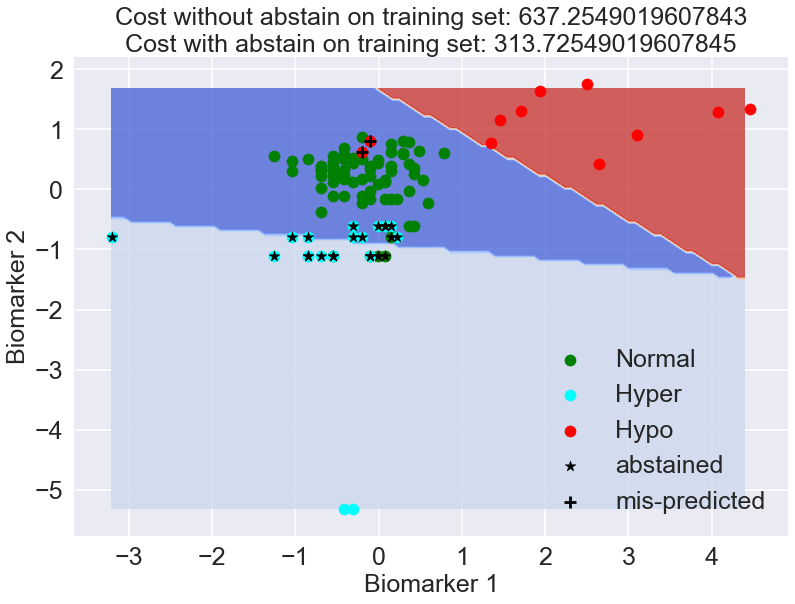

In [22]:
figs, axes = plt.subplots(1, 1)
title = 'Cost without abstain on training set: {}\nCost with abstain on training set: {}'.format(mc[3], mc[4])
plot_decision_boundary2(X_train_normed, y_train, y_train_pred, logitm, title, axes)
plt.legend(loc=4, fontsize=25);
for item in ([axes.title, axes.xaxis.label, axes.yaxis.label] +
             axes.get_xticklabels() + axes.get_yticklabels()):
    item.set_fontsize(25)
plt.savefig('db_train.png', bbox_inches='tight');

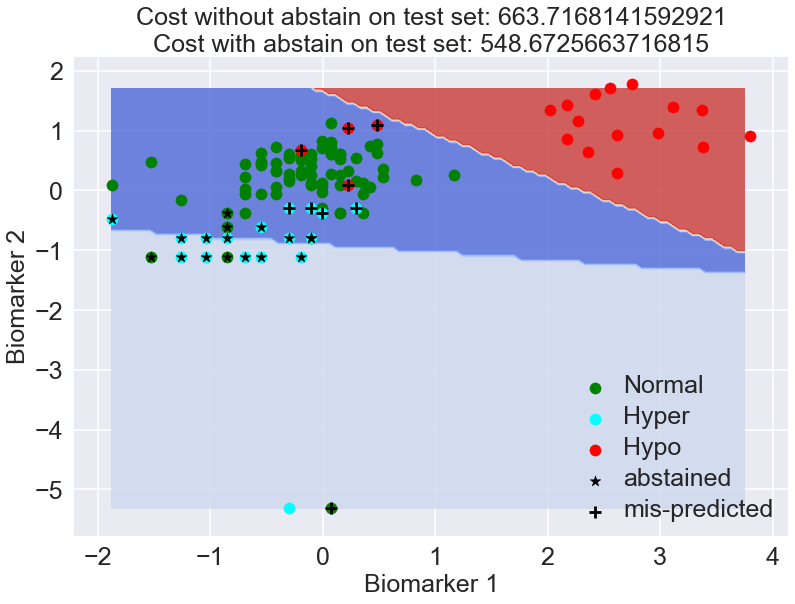

In [23]:
figs, axes = plt.subplots(1, 1)
title = 'Cost without abstain on test set: {}\nCost with abstain on test set: {}'.format(mc[5], mc[6])
plot_decision_boundary2(X_test_normed, y_test, y_test_pred, logitm, title, axes)
plt.legend(loc=3);
for item in ([axes.title, axes.xaxis.label, axes.yaxis.label] +
             axes.get_xticklabels() + axes.get_yticklabels() + axes.legend().get_texts()):
    item.set_fontsize(25)
plt.savefig('db_test.png', bbox_inches='tight');

As we can see, samples close to the decision boundry of 'normal' and 'hyper' group are classified as 'abstain', which reduced cost per patient by avoiding many mis-predictions. 

To test the robustness of this approach, we can test on different mis-prediction costs and abstain costs.

In [24]:
mcs = [min_cost(10000, 1000),
       min_cost(8000, 1000),
       min_cost(5000, 1000),
       min_cost(5000, 2500),
       min_cost(5000, 5000)]

Cost: mis-prediction $10000; abstain $1000.
The abstain threshold is [ 0.88  0.6   0.14].
The average cost per patient (without abstain) on the training set is 1274.5098039215686.
The average cost per patient (with abstain) on the training set is 362.7450980392157.
The average cost per patient (without abstain) on the test set is 1327.4336283185842.
The average cost per patient (with abstain) on the test set is 769.9115044247787.

Cost: mis-prediction $8000; abstain $1000.
The abstain threshold is [ 0.88  0.6   0.14].
The average cost per patient (without abstain) on the training set is 1019.6078431372549.
The average cost per patient (with abstain) on the training set is 343.1372549019608.
The average cost per patient (without abstain) on the test set is 1061.9469026548672.
The average cost per patient (with abstain) on the test set is 663.7168141592921.

Cost: mis-prediction $5000; abstain $1000.
The abstain threshold is [ 0.72  0.6   0.02].
The average cost per patient (without abst

In [25]:
results = {
    'mis-prediction cost': [mc[0] for mc in mcs],
    'abstain cost': [mc[1] for mc in mcs],
    'threshold for class 1 (Normal)': [mc[2][0] for mc in mcs],
    'threshold for class 2 (Hyper)': [mc[2][1] for mc in mcs],
    'threshold for class 3 (Hypo)': [mc[2][2] for mc in mcs],
    'without abstain': [mc[5] for mc in mcs],
    'with abstain': [mc[6] for mc in mcs]
}

dfresults = pd.DataFrame.from_dict(results)

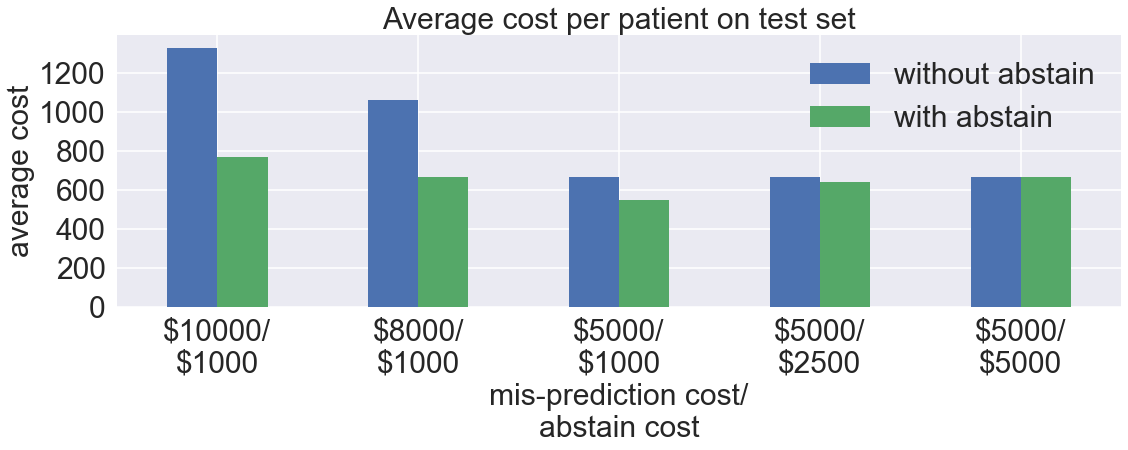

In [26]:
dfresults[['without abstain', 'with abstain']].plot(kind='bar', figsize=(18, 5), fontsize=30);
xticks = ['${}/\n${}'.format(mc[0], mc[1]) for mc in mcs];
plt.xticks(range(len(dfresults)), xticks, rotation=0);
plt.xlabel('mis-prediction cost/\nabstain cost', fontsize=30);
plt.ylabel('average cost', fontsize=30);
plt.title('Average cost per patient on test set', fontsize=30);
plt.legend(fontsize=30);
plt.savefig('costs.png', bbox_inches='tight');

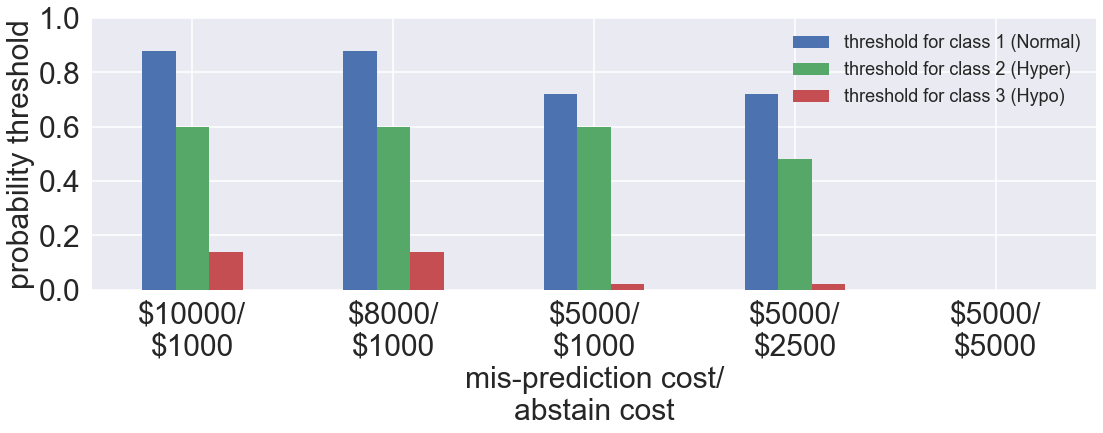

In [27]:
dfresults[['threshold for class 1 (Normal)', 'threshold for class 2 (Hyper)', \
           'threshold for class 3 (Hypo)']].plot(kind='bar', figsize=(18, 5), fontsize=30);
plt.ylim([0, 1]);
xticks = ['${}/\n${}'.format(mc[0], mc[1]) for mc in mcs];
plt.xticks(range(len(dfresults)), xticks, rotation=0, fontsize=30);
plt.xlabel('mis-prediction cost/\nabstain cost', fontsize=30);
plt.ylabel('probability threshold', fontsize=30);
plt.legend(fontsize=18);
plt.savefig('thresholds.png', bbox_inches='tight');

When abstain cost is lower than mis-prediction cost, our approach always finds a set of thresholds resulting in lower cost, which holds for both training set and test set, by learning from the training set. When abstain cost is same as mis-prediction cost and the abstain option, as a result, wouldn't be helpful, thresholds are set to 0, which means no abstain option would be used. The results demonstrate our approach is robust to changes in the costs of using the abstain option.

In [1]:
# Q2

from IPython.display import IFrame
IFrame('hw7_part5_2.pdf', width=600, height=300)